In [1]:
# Import packages
import pandas as pd
import numpy as np
import scipy.stats as stats
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

import Orthoscripts

# Disable chained assignments
pd.options.mode.chained_assignment = None 

#### Import genelists

In [2]:
# Asterias rubens
Astrub = Orthoscripts.readBED("Data/Genelists/Asterias.rubens.genelist.bed")

# Holothuria leucospilota
Holleu = Orthoscripts.readBED("Data/Genelists/Holothuria.leucospilota.genelist.bed")

# Paracentrotus livides
Parliv = Orthoscripts.readBED("Data/Genelists/Paracentrotus.lividus.genelist.bed")

# Branchiostoma lanceolatum
Bralan = Orthoscripts.readBED("Data/Genelists/Branchiostoma.lanceolatum.genelist.bed")

# Branchiostoma floridae
Braflo = Orthoscripts.readBED("Data/Genelists/Branchiostoma.floridae.genelist.bed")

# Marthasterias glacialis
Margla = Orthoscripts.readBED("Data/Genelists/Marthasterias.glacialis.genelist.bed")

# Pecten maximus
Pecmax = Orthoscripts.readBED("Data/Genelists/Pecmax.genelist.bed")

# Stichopus chloronotus
Stichl = Orthoscripts.readBED("Data/Genelists/Stichopus.chloronotus.genelist.bed")

# Amphiura filiformis 
Ampfil = Orthoscripts.readBED("Data/Genelists/Amphiura.filiformis.genelist.bed")

# Ancestor 
Ancestor = Orthoscripts.readBED("Data/Genelists/Ancestor.genelist.bed")

#### Import ortholog files

In [3]:
# Import orthologs
Astrub_Holleu = np.loadtxt("Data/Orthologs/Asterias.rubens+Holothuria.leucospilota.txt", dtype = "str")

Astrub_Parliv = np.loadtxt("Data/Orthologs/Asterias.rubens+Paracentrotus.lividus.txt", dtype = "str")

Holleu_Parliv = np.loadtxt("Data/Orthologs/Holothuria.leucospilota+Paracentrotus.lividus.txt", dtype = "str")

Margla_Bralan = np.loadtxt("Data/Orthologs/Marthasterias.glacialis+Branchiostoma.lanceolatum.txt", dtype = "str")

Margla_Pecmax = np.loadtxt("Data/Orthologs/Marthasterias.glacialis+Pecten.maximus.txt", dtype = "str")

Margla_Stichl = np.loadtxt("Data/Orthologs/Marthasterias.glacialis+Stichopus.chloronotus.txt", dtype = "str")

Pecmax_Bralan = np.loadtxt("Data/Orthologs/Pecten.maximus+Branchiostoma.lanceolatum.txt", dtype = "str")

Stichl_Bralan = np.loadtxt("Data/Orthologs/Stichopus.chloronotus+Branchiostoma.lanceolatum.txt", dtype = "str")

Stichl_Pecmax = np.loadtxt("Data/Orthologs/Stichopus.chloronotus+Pecten.maximus.txt", dtype = "str")

Pecmax_Holleu = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Holleu_sensitive.txt", dtype = "str")

Holleu_Bralan = np.loadtxt("Orthology pipeline/orthologs/Holleu+Bralan_sensitive.txt", dtype = "str")

Pecmax_Bralan = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Bralan_sensitive.txt", dtype = "str")

Pecmax_Braflo = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Braflo_sensitive.txt", dtype = "str")

Holleu_Braflo = np.loadtxt("Orthology pipeline/orthologs/Holleu+Braflo_sensitive.txt", dtype = "str")

Holleu_Ampfil = np.loadtxt("Data/Orthologs/Holothuria.leucospilota+Amphiura.filiformis.txt", dtype = "str")

#### Sorting out the data

In [4]:
Astrub = Astrub.loc[Astrub['Chromosome'].str.contains('chr')]
Bralan = Bralan.loc[Bralan['Chromosome'].str.contains('BFL_')]
Braflo = Braflo.loc[Braflo['Chromosome'].str.contains('BFL_')]
Pecmax = Pecmax.loc[Pecmax['Chromosome'].str.contains('PYE_')]

# Parliv genelist: select chromosomal scaffolds
Parliv = Orthoscripts.unscaff(Parliv, 100)
Ampfil = Orthoscripts.unscaff(Ampfil, 100)

Astrub_Parliv = Orthoscripts.orthFix(Astrub_Parliv, 'B', 'Parliv_', 1)
Margla_Bralan = Orthoscripts.orthFix(Margla_Bralan, 'A', '.1', 0)
Margla_Stichl = Orthoscripts.orthFix(Margla_Stichl, 'A', '.1', 0)
Margla_Stichl = Orthoscripts.orthFix(Margla_Stichl, 'B', '.1', 0)
Margla_Pecmax = Orthoscripts.orthFix(Margla_Pecmax, 'B', '.1', 0)
Holleu_Bralan = Orthoscripts.orthFix(Holleu_Bralan, 'B', '_', 0)
Holleu_Ampfil = Orthoscripts.orthFix(Holleu_Ampfil, 'B', '.1', 0)

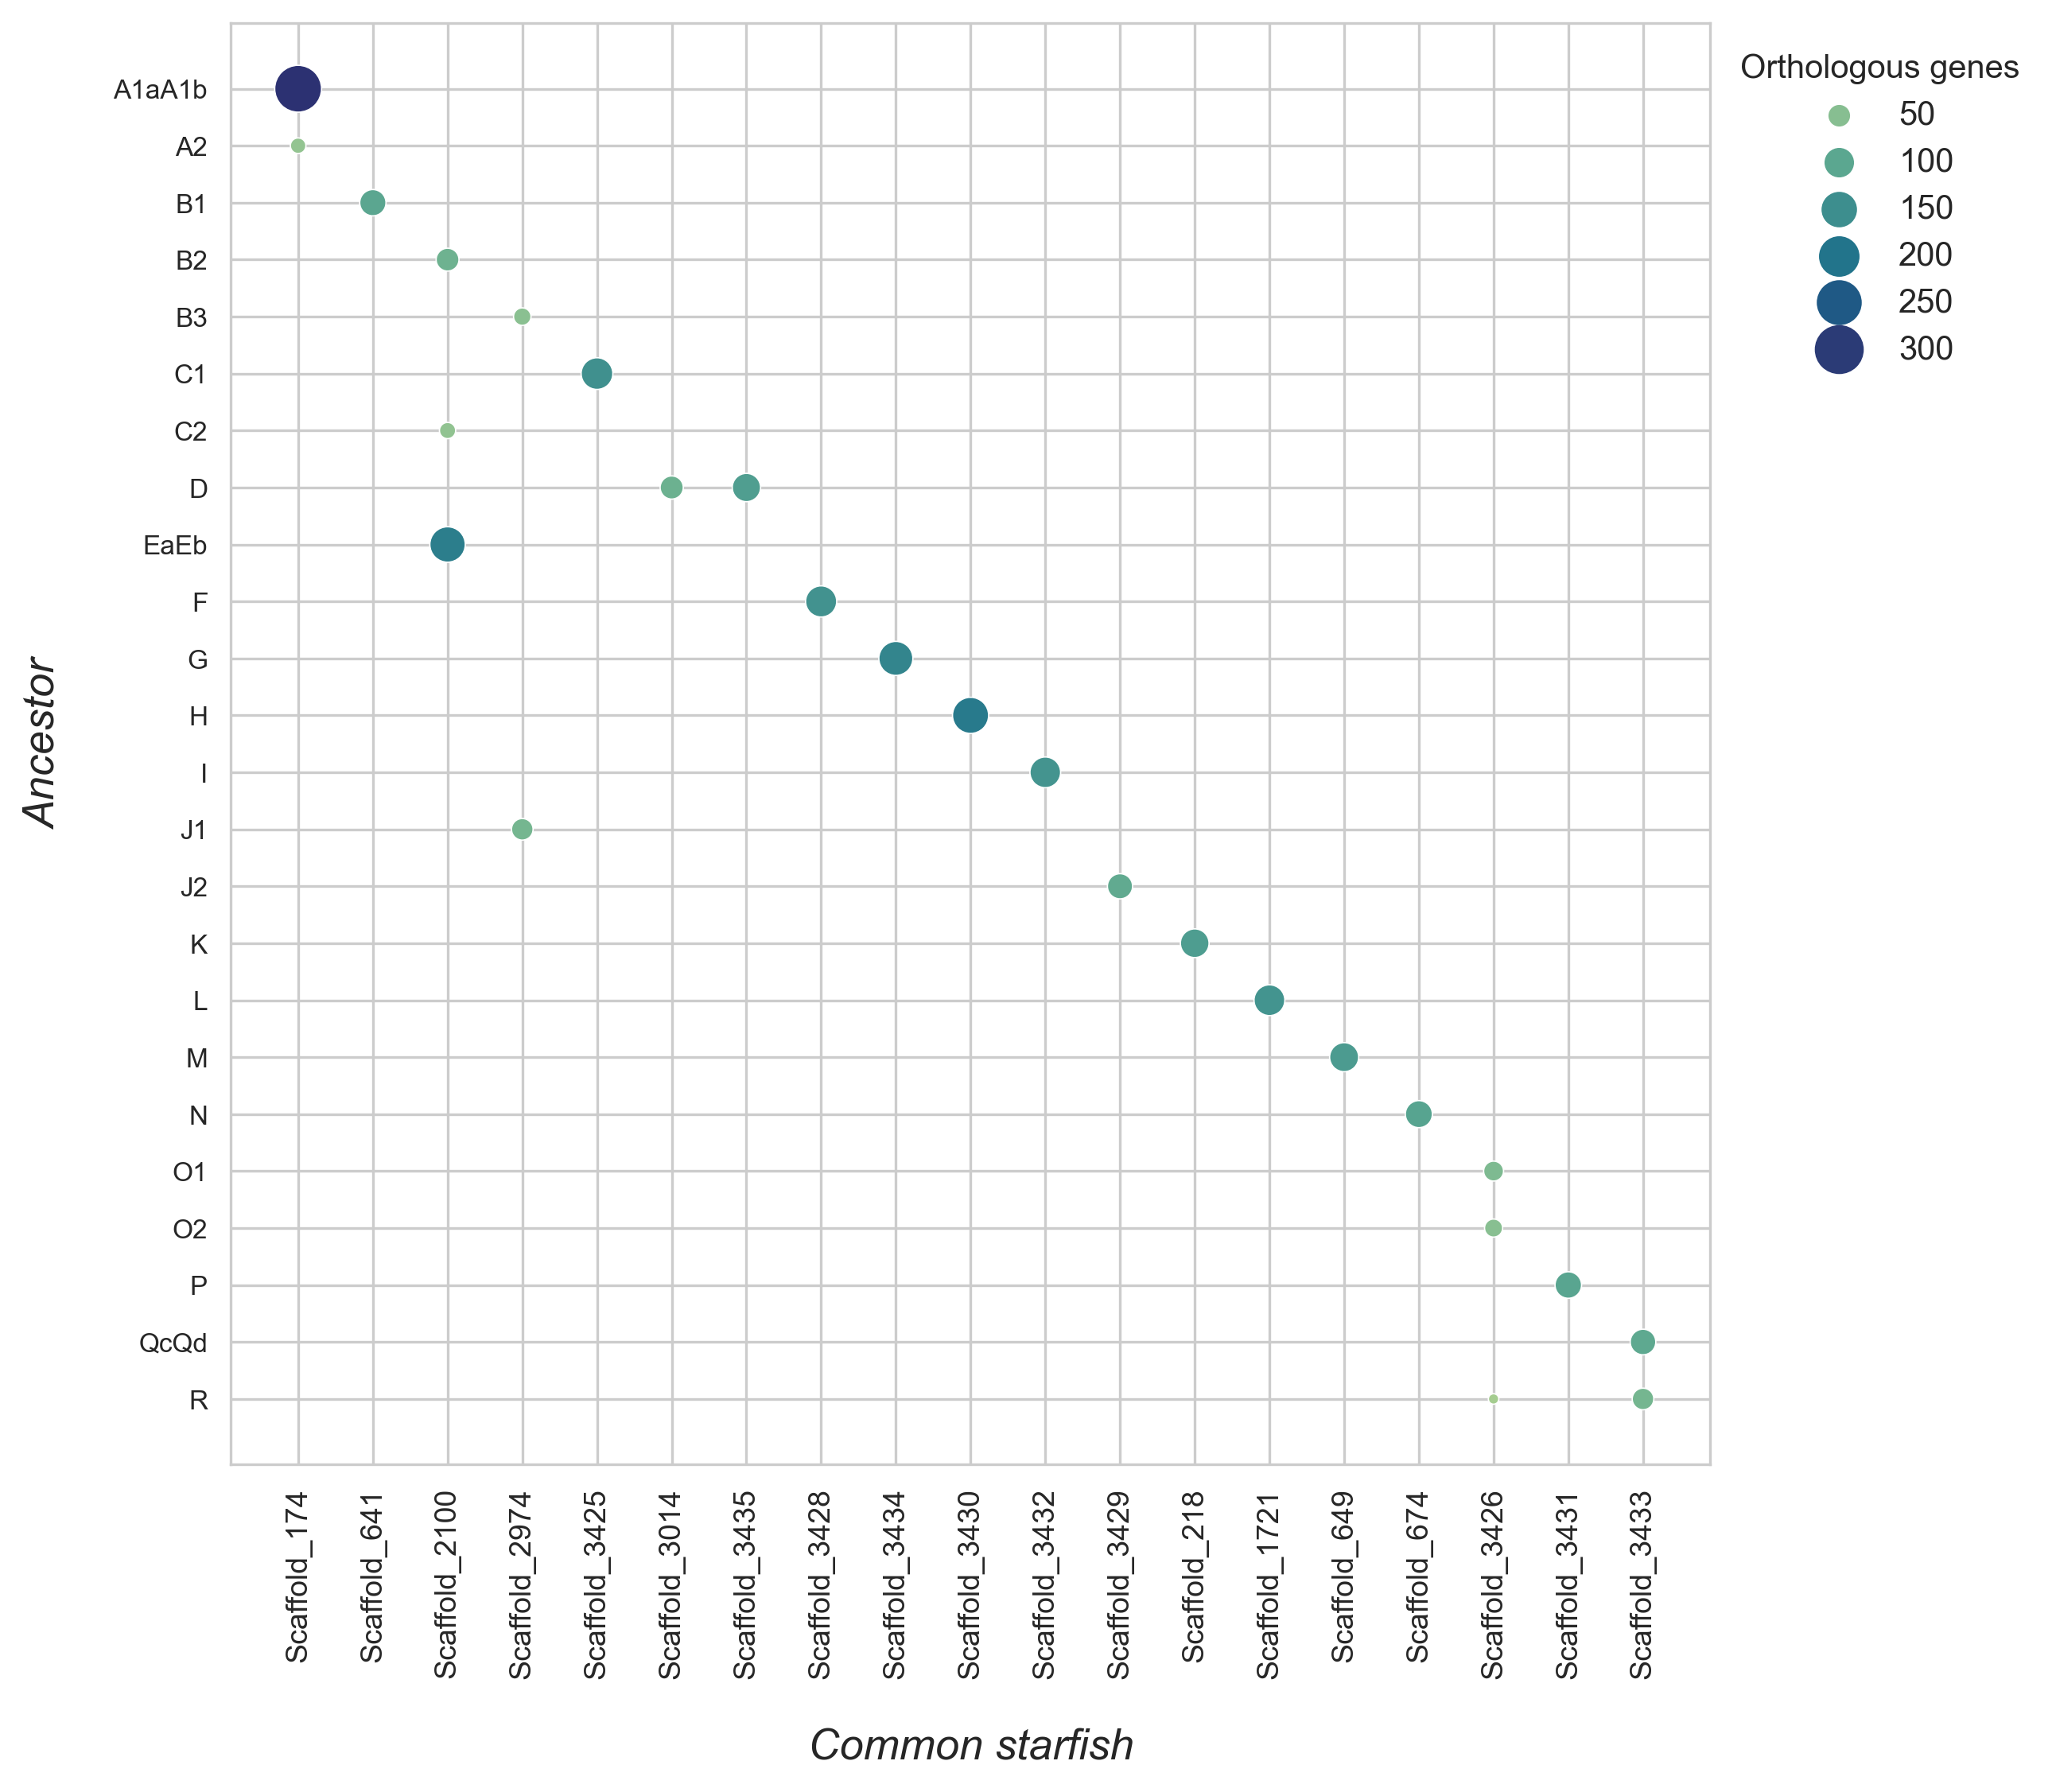

In [33]:
AB = Orthoscripts.orthofy(Ancestor, Parliv, Holleu_Parliv)
Orthoscripts.orthoplot(AB, 'Common starfish', 'Ancestor', 'B', 'A')

In [34]:
Orthoscripts.rearrangements(AB)

Fusions: 7
['Scaffold_174', 'Scaffold_2100', 'Scaffold_2974', 'Scaffold_3426', 'Scaffold_3433']
Fissions: 2
['D', 'R']
